# multiclass image classificationM

* become one with the data
* preprocess the data
* create model -> compile
* fit and validate
* visualize the model, loss curve
* tweak and improve 

In [2]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
import zipfile
zip = zipfile.ZipFile('10_food_classes_all_data.zip')
zip.extractall()
zip.close()

In [4]:
import os
for root, dirs, files in os.walk("10_food_classes_all_data"):
  print(f'there are {len(dirs)} directories and {len(files)} files in folder "{root}"')

there are 2 directories and 0 files in folder "10_food_classes_all_data"
there are 10 directories and 0 files in folder "10_food_classes_all_data/test"
there are 0 directories and 250 files in folder "10_food_classes_all_data/test/ramen"
there are 0 directories and 250 files in folder "10_food_classes_all_data/test/pizza"
there are 0 directories and 250 files in folder "10_food_classes_all_data/test/hamburger"
there are 0 directories and 250 files in folder "10_food_classes_all_data/test/chicken_wings"
there are 0 directories and 250 files in folder "10_food_classes_all_data/test/ice_cream"
there are 0 directories and 250 files in folder "10_food_classes_all_data/test/chicken_curry"
there are 0 directories and 250 files in folder "10_food_classes_all_data/test/fried_rice"
there are 0 directories and 250 files in folder "10_food_classes_all_data/test/steak"
there are 0 directories and 250 files in folder "10_food_classes_all_data/test/sushi"
there are 0 directories and 250 files in fold

In [6]:
train_dir = '10_food_classes_all_data/train/'
test_dir = '10_food_classes_all_data/test/'

In [13]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = [item.name for item in data_dir.glob('*')]
class_names = sorted(class_names)
class_names = np.array(class_names)
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [14]:
# let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class

  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)
  
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis(False)

  print(f'Image shape: {img.shape}')

  return img

['506864.jpg']
Image shape: (512, 512, 3)


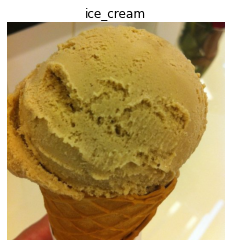

In [17]:
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

### 2. preprocess the data

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)

test_datagen = ImageDataGenerator(rescale=1/255)

In [26]:
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224,224),
                                               class_mode='categorical',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224,224),
                                               class_mode='categorical',
                                               batch_size=32)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [27]:
images, labels = train_data.next()

In [28]:
images.shape, labels.shape

((32, 224, 224, 3), (32, 10))

In [29]:
labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

### 3. create a model (start with a baseline)

replicate the one of CNN explainer

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [31]:
tf.random.set_seed(42)
model_1 = Sequential([
                      Conv2D(10,3,activation='relu'),
                      Conv2D(10,3,activation='relu'),
                      MaxPool2D(2),
                      Conv2D(10,3,activation='relu'),
                      Conv2D(10,3,activation='relu'),
                      MaxPool2D(2),
                      Flatten(),
                      Dense(10, activation='softmax')
])

In [32]:
from tensorflow.keras.optimizers import Adam

model_1.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

### fit the model

In [34]:
history_1 = model_1.fit(train_data,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
235/235 [==============================] - 598s 3s/step - loss: 2.1782 - accuracy: 0.1892 - val_loss: 1.9827 - val_accuracy: 0.2892
Epoch 2/5
235/235 [==============================] - 598s 3s/step - loss: 2.0704 - accuracy: 0.2607 - val_loss: 1.8883 - val_accuracy: 0.3436
Epoch 3/5
235/235 [==============================] - 594s 3s/step - loss: 2.0105 - accuracy: 0.2944 - val_loss: 1.8349 - val_accuracy: 0.3648
Epoch 4/5
235/235 [==============================] - 594s 3s/step - loss: 1.9760 - accuracy: 0.3157 - val_loss: 1.8080 - val_accuracy: 0.3780
Epoch 5/5
235/235 [==============================] - 594s 3s/step - loss: 1.9302 - accuracy: 0.3345 - val_loss: 1.7623 - val_accuracy: 0.3968


In [37]:
model_1.evaluate(test_data)

79/79 [==============================] - 54s 675ms/step - loss: 1.7623 - accuracy: 0.3968


[1.7622880935668945, 0.3968000113964081]

In [35]:
### 5. evaluate the model
# plot the validation and training curves separately
def plot_loss_curves(history):
  """
  returns separate loss curves for training and validation metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

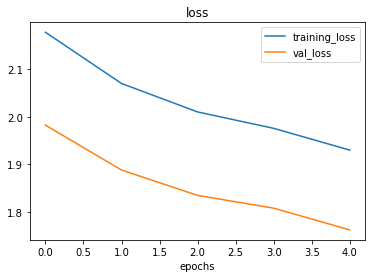

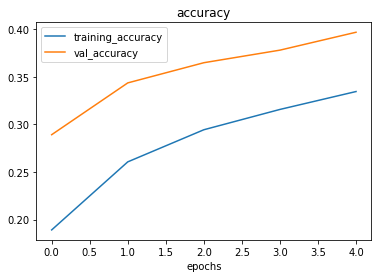

In [36]:
plot_loss_curves(history_1)

### adjust the model hyperparameters

In [38]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 10)    280       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 10)    910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 10)   0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 10)    910       
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 10)    910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 10)   0         
 2D)                                                    

In [39]:
# how about simplify our model first
# let's remove 2 conv2D layers
model_2 = Sequential([
            Conv2D(10,3,activation='relu'),
            MaxPool2D(2),
            Conv2D(10,3,activation='relu'),
            MaxPool2D(2),
            Flatten(),
            Dense(10, activation='softmax')
])

model_2.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [40]:
history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
235/235 [==============================] - 319s 1s/step - loss: 2.2101 - accuracy: 0.2056 - val_loss: 1.9896 - val_accuracy: 0.3100
Epoch 2/5
235/235 [==============================] - 323s 1s/step - loss: 2.0482 - accuracy: 0.2753 - val_loss: 1.9082 - val_accuracy: 0.3516
Epoch 3/5
235/235 [==============================] - 319s 1s/step - loss: 1.9957 - accuracy: 0.3043 - val_loss: 1.9733 - val_accuracy: 0.3136
Epoch 4/5
235/235 [==============================] - 316s 1s/step - loss: 1.9542 - accuracy: 0.3273 - val_loss: 1.8835 - val_accuracy: 0.3432
Epoch 5/5
235/235 [==============================] - 334s 1s/step - loss: 1.9378 - accuracy: 0.3319 - val_loss: 1.8978 - val_accuracy: 0.3584


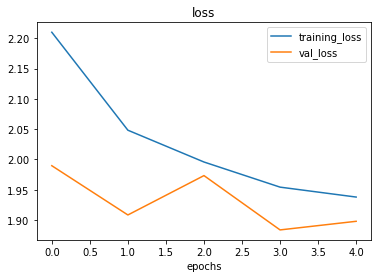

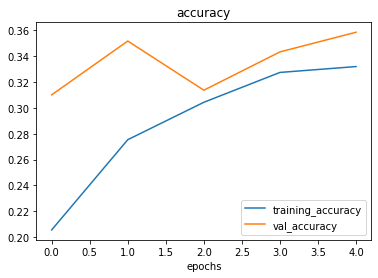

In [42]:
plot_loss_curves(history_2)

### 7. repeat until satisfied
* 

## save and load our model

In [43]:
model_1.save('saved_trained_model_1')

INFO:tensorflow:Assets written to: saved_trained_model_1/assets


In [44]:
loaded_model_1 = tf.keras.models.load_model('saved_trained_model_1')
loaded_model_1.evaluate(test_data)

79/79 [==============================] - 54s 675ms/step - loss: 1.7623 - accuracy: 0.3968


[1.7622880935668945, 0.3968000113964081]